# Weather forecasting with PySpark
## Big Data Computing final project

Setting up some Configuration Constants globally

In [0]:
#Configuration constants
DATASET = 'dbfs:/bigdata_proj/datasets/historical-hourly-weather/'
MODELS = 'dbfs:/bigdata_proj/models/historical-hourly-weather/'
RANDOM_SEED = 42


## Setting up the workflow options and databricks limitations

This code snippet primarily establishes paths to data and model files and sets flags to control the overall workflow:

- Path Management: Organizing where data, models, and the encoding pipeline will be stored.
- Flexibility: Allowing the user to decide whether to load pre-existing elements or generate them during execution.
- DataBricks Adaptation: Addresses a size limitation specific to the DataBricks environment.

In [0]:


# Workflow Options
RANDOM_FOREST_MODEL_PATH = f'{MODELS}rnd_forest'
RANDOM_FOREST_CV_MODEL_PATH = f'{MODELS}rnd_forest_cv'  # Cross-validated model
LOGISTIC_REGRESSION_CV_MODEL_PATH = f'{MODELS}log_reg_cv' 
SAMPLED_DATASET_PATH = f'{DATASET}aggregated_sampled_weather_measurements.csv'
ENCODING_PIPELINE_PATH = f'{MODELS}data_encoder'

SAVE_COMPUTATIONS = True  # Flag to save intermediate results
LOAD_SAMPLED_DATASET = False  # Load pre-sampled dataset or generate from raw data
LOAD_ENCODING_PIPELINE = False  # Load pre-built encoding pipeline or create from scratch
LOAD_PRETRAINED_MODELS = False  # Load existing models or train new ones

# DataBricks Limitation Workaround
MAX_TRAIN_SIZE = 999_999  # Maximum training dataset size due to community edition limits

#### Importing the required dependencies

In [0]:
# Machine Learning Modules
from pyspark.ml.pipeline import PipelineModel  # For loading trained ML pipelines
from pyspark.ml.tuning import CrossValidatorModel  # For loading cross-validated models

# PySpark Setup (consider clarifying if these settings are required for your project)
from pyspark import SparkContext, SparkConf  # Initializing Spark
from pyspark.sql import *  # PySpark SQL for data manipulation
from pyspark.sql.types import *  # For defining data types
from pyspark.sql.functions import *  # PySpark functions for data transformations

from typing import *  # Optional, for type hints if desired

import pyspark  # Main PySpark module
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualizations



## Starting with Data Initialisation

### First we are downloading the dataset

Our source is [kaggle.com/selfishgene/historical-hourly-weather-data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data)

In [0]:
%sh
# Download the dataset from GitHub and save it as dataset.zip in the /tmp directory
wget --no-verbose https://github.com/SouravGanesh/BigData_DataSet/raw/main/dataset/historical-hourly-weather-dataset.zip -O /tmp/dataset.zip

# Unzip the dataset.zip file and extract its contents into the /tmp/dataset directory
unzip -u /tmp/dataset.zip -d /tmp/dataset

2024-04-03 21:57:49 URL:https://raw.githubusercontent.com/SouravGanesh/BigData_DataSet/main/dataset/historical-hourly-weather-dataset.zip [12655281/12655281] -> "/tmp/dataset.zip" [1]


Archive:  /tmp/dataset.zip
   creating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/._committed_7616641238230246128.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00000-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5515-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00006-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5521-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00002-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5517-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00004-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5519-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/part-00003-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413

#### Now moving the dataset from the temporary location i.e Databricks local driver node's file system to DBFS

In [0]:
# Move files from temporary location to dataset path
for f in dbutils.fs.ls('file:/tmp/dataset'):
    dbutils.fs.mv(f.path, f'{DATASET}{f.name}', recurse=True)

#### Listing all the directories to verify

In [0]:
%fs ls /bigdata_proj/datasets/historical-hourly-weather

path,name,size,modificationTime
dbfs:/bigdata_proj/datasets/historical-hourly-weather/aggregated_sampled_weather_measurements.csv/,aggregated_sampled_weather_measurements.csv/,0,1710607244000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/city_attributes.csv,city_attributes.csv,1614,1712181475000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/humidity.csv,humidity.csv,9075077,1712181474000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/pressure.csv,pressure.csv,12155911,1712181475000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/temperature.csv,temperature.csv,13971171,1712181475000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/weather_description.csv,weather_description.csv,21858089,1712181474000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_direction.csv,wind_direction.csv,10171003,1712181473000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_speed.csv,wind_speed.csv,7457531,1712181473000


### Taking the use of Spark here by loading the data set for processing

### Dataset shape and schema is as follows
Dataset Overview

The raw dataset, obtained from Kaggle, consists of seven CSV files. Let's break down their contents and structure:

- city_attributes.csv

Provides geographic details about various cities included in the weather measurements.
- weather_description.csv

Offers text-based descriptions of weather conditions.
Structure:
Columns: Represent different cities.
Rows: Indicate specific datetimes for weather condition observations.
- Other 5 csv files

Contain measurements for these metrics: humidity, pressure, temperature, wind direction, wind speed.
Share a similar structure to 'weather_description.csv'
Dataset Size

Approximately 45,000 hourly weather records per file (excluding 'city_attributes.csv').
With 36 cities, the total dataset approaches 1.5 million records.

In [0]:
# Import the necessary module
from pyspark.sql import SparkSession

# Create or get the SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the CSV files into DataFrames
temperature_df = spark.read.csv(f'{DATASET}temperature.csv', inferSchema=True, header=True)
wind_speed_df = spark.read.csv(f'{DATASET}wind_speed.csv',inferSchema=True, header=True)
weather_conditions_df = spark.read.csv(f'{DATASET}weather_description.csv', inferSchema=True, header=True)
humidity_df = spark.read.csv(f'{DATASET}humidity.csv',inferSchema=True, header=True)
city_attributes_df = spark.read.csv(f'{DATASET}city_attributes.csv', inferSchema=True, header=True)
wind_direction_df = spark.read.csv(f'{DATASET}wind_direction.csv', inferSchema=True, header=True)
pressure_df = spark.read.csv(f'{DATASET}pressure.csv', inferSchema=True, header=True)



#Data Preprocessing

#### These are the columns names we'll we working with

In [0]:
# Define column names
DATETIME_C = 'datetime'
HUMIDITY_C = 'humidity'
PRESSURE_C = 'pressure'
TEMPERATURE_C = 'temperature'
WIND_DIRECTION_C = 'wind_direction'
WIND_SPEED_C = 'wind_speed'
LATITUDE_C = 'latitude'
LONGITUDE_C = 'longitude'
CITY_C = 'city'
COUNTRY_C = 'country'
WEATHER_CONDITION_C = 'weather_condition'

#### Filtering a DataFrame based on a specific city column and rename the column

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

'''
    Filter a DataFrame based on a specific city column and rename the column.

    Args:
        - dataframe: Original DataFrame with a datetime column and city columns
        - city_name: Name of the city to filter on
        - new_column_name: New name to give to the city column after renaming

    Returns:
        A new DataFrame with the datetime column and a single column containing
        the measurements related to the specified city and renamed as new_column_name.
'''

def filter_by_citycolumn(df: DataFrame, city: str, new_column: str) -> DataFrame:
    return df.withColumn(new_column, col(city)) \
                    .select([DATETIME_C, new_column])

#### We are joining the dataframes here over the column specified by the column name
- Set the initial DataFrame for the join operation
- Iterate through the remaining DataFrames and join them to the initial DataFrame
- Return the final joined DataFrame

In [0]:
'''
    Args:
        - dataframes: a list of DataFrames to be joined
        - column_name: the column over which the records should be joined
        
    Returns:
        A new DataFrame resulting from joining all the DataFrames
        over the column specified by column_name
'''
def join_dataframes(df: List[DataFrame], column: str) -> DataFrame:

    # Set the initial DataFrame for the join operation
    joined_df = df[0]

    # Iterate through the remaining DataFrames and join them to the initial DataFrame
    for df1 in df[1:]:
        joined_df = joined_df.join(df1, [column])

    # Return the final joined DataFrame
    return joined_df

In [0]:
from pyspark.sql import Row

# Initialize the weather_measurements_df variable to store the final DataFrame
weather_measurements_df = None

# Collect the rows from city_attributes_df as a list
city_attributes = city_attributes_df.collect()

# Iterate over each row in city_attributes
for row in city_attributes:
    # Get the values from the row
    latitude = row.Latitude
    longitude = row.Longitude
    city = row.City
    country = row.Country

    # Create a list of DataFrames for each type of measurement in the city
    df = [
        filter_by_citycolumn(humidity_df, city, HUMIDITY_C),
        filter_by_citycolumn(pressure_df, city, PRESSURE_C),
        filter_by_citycolumn(temperature_df, city, TEMPERATURE_C),
        filter_by_citycolumn(wind_direction_df, city, WIND_DIRECTION_C),
        filter_by_citycolumn(wind_speed_df, city, WIND_SPEED_C),
        filter_by_citycolumn(weather_conditions_df, city, WEATHER_CONDITION_C)
    ]

    # Join the DataFrames based on the DATETIME_C column and add additional columns
    joined_df = join_dataframes(df, DATETIME_C) \
        .withColumn(CITY_C, lit(city)) \
        .withColumn(COUNTRY_C, lit(country)) \
        .withColumn(LATITUDE_C, lit(latitude)) \
        .withColumn(LONGITUDE_C, lit(longitude))

    # Union the joined DataFrame with the previous weather_measurements_df
    if weather_measurements_df is not None:
        weather_measurements_df = weather_measurements_df.union(joined_df)
    else:
        weather_measurements_df = joined_df

#### Showing the firse five rows to verify whats going on and Printing the count of missing values in each column

In [0]:
# Show the first 5 rows of the weather_measurements_df DataFrame
weather_measurements_df.show(5)

# Iterate over each column in weather_measurements_df
for c in weather_measurements_df.columns:
    # Print the count of missing values in the column
    print(f'Count for missing values for column `{c}` is {weather_measurements_df.where(col(c).isNull()).count()}')

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-01 12:00:00|    NULL|    NULL|         NULL|          NULL|      NULL|             NULL|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 13:00:00|    76.0|    NULL|       284.63|           0.0|       0.0|             mist|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 14:00:00|    76.0|    NULL| 284.62904131|           6.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 15:00:00|    76.0|    NULL|284.626997923|          20.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 16:00:00|    77.0|    NULL|28

#### Replacing the empty null values with the mean of value of each group of weather conditions.

In [0]:
weather_measurements_df = weather_measurements_df.dropna(subset=['weather_condition'])

import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Define a window partitioned by 'weather_condition' for calculating mean
windowSpec = Window.partitionBy('weather_condition')

# Define the columns you want to replace missing values for
columns_to_fill = ['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']

# Calculate the mean for each group of 'weather_condition' for all columns at once
mean_df = weather_measurements_df.select('weather_condition', *[
    F.mean(col).over(windowSpec).alias(col + '_mean') for col in columns_to_fill]).distinct()

# Join the mean_df with the original DataFrame on 'weather_condition' column
weather_measurements_df = weather_measurements_df.join(mean_df, on='weather_condition', how='left')

# Fill null values in the original DataFrame using the calculated mean for each group
for col in columns_to_fill:
    weather_measurements_df = weather_measurements_df.withColumn(col, F.when(weather_measurements_df[col].isNull(), weather_measurements_df[col + '_mean']).otherwise(weather_measurements_df[col]))

# Drop the columns containing mean values
weather_measurements_df = weather_measurements_df.drop(*[col + '_mean' for col in columns_to_fill])

weather_measurements_df.persist()

DataFrame[weather_condition: string, datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, city: string, country: string, latitude: double, longitude: double]

###Printing the count of missing values in each column after replacing

In [0]:
from pyspark.sql.functions import col

for c in weather_measurements_df.columns:
    print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

Missing values of column `weather_condition` count: 0
Missing values of column `datetime` count: 0
Missing values of column `humidity` count: 0
Missing values of column `pressure` count: 0
Missing values of column `temperature` count: 0
Missing values of column `wind_direction` count: 0
Missing values of column `wind_speed` count: 0
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0


#### Grouping the dataframe by the WEATHER_CONDITION_C column and then counting the number 
- Group the filtered_weather_measurements_df DataFrame by the WEATHER_CONDITION_C column
- and count the number of occurrences for each distinct weather condition
- Show the result without truncating the output


In [0]:
filtered_weather_measurements_df = weather_measurements_df
filtered_weather_measurements_df.persist()

all_condition = filtered_weather_measurements_df.groupBy(WEATHER_CONDITION_C).count().collect()

#### Defining a function that takes an iterable collection of string weather conditions and returns a dictionary and the function aggregates the weather conditions into specific categories

In [0]:
def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        a dictionary that goes from the original weather condition name to one among the following:
            - rainy
            - snowy
            - cloudy
            - sunny
    '''
    
    weather_conditions_dict = dict()
  
    for weather_condition in weather_conditions:
  
        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'overcast clouds' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['clear']):
            weather_conditions_dict[weather_condition] = 'sunny'
            
    return weather_conditions_dict

%md
#### Retrieving all distinct weather conditions from the filtered_weather_measurements_df DataFrame
- Select the WEATHER_CONDITION_C column from the DataFrame
- Apply the distinct() function to get the unique values
- Convert the result to an RDD
- Collect the values as a list



In [0]:
weather_conditions_all = filtered_weather_measurements_df \
    .select(WEATHER_CONDITION_C).distinct() \
    .rdd.map(lambda row: row[0]) \
    .collect()

In [0]:
# Create a dictionary that aggregates weather conditions into specific categories
# Call the function aggregation_weather_dict() with the input of all weather conditions
# Store the resulting dictionary in the variable weather_conditions_dict
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

In [0]:
# Replace the weather conditions in the filtered_weather_measurements_df DataFrame using the weather_conditions_dict
# Store the result in the weather_aggregated_df DataFrame
weather_aggregated_df = filtered_weather_measurements_df.replace(weather_conditions_dict)

# Persist the weather_aggregated_df DataFrame in memory for faster access
weather_aggregated_df.persist()

DataFrame[weather_condition: string, datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, city: string, country: string, latitude: double, longitude: double]

#### Getting the unique set of weather conditions and filtering  to include only rows where the weather condition is in the unique set of weather conditions 

In [0]:
# Get the unique set of weather conditions from the existing dictionary
unique_weather_conditions = set(weather_conditions_dict.values())

# Filter the weather_aggregated_df DataFrame to include only rows where the weather condition is in the unique set of weather conditions
filtered_weather_measurements_aggregated_df = weather_aggregated_df \
    .filter(weather_aggregated_df[WEATHER_CONDITION_C].isin(unique_weather_conditions))

#### Grouping the resulting dataframe by the WEATHER_CONDITION_C column and then counting the number of occurences for distinct weather condition

In [0]:
# Group the filtered_weather_measurements_aggregated_df DataFrame by the values in the WEATHER_CONDITION_C column
# Count the number of occurrences for each unique value in the WEATHER_CONDITION_C column
# Show the results
filtered_weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_C).count().show()

+-----------------+------+
|weather_condition| count|
+-----------------+------+
|            rainy|207834|
|            snowy| 21850|
|           cloudy|137604|
|            sunny|651226|
+-----------------+------+



#### Verifying how data loooks

In [0]:
# Show the first 5 rows of the filtered_weather_measurements_aggregated_df DataFrame
filtered_weather_measurements_aggregated_df.show(5)

+-----------------+-------------------+--------+--------+-----------+--------------+----------+-------------+-------------+---------+-----------+
|weather_condition|           datetime|humidity|pressure|temperature|wind_direction|wind_speed|         city|      country| latitude|  longitude|
+-----------------+-------------------+--------+--------+-----------+--------------+----------+-------------+-------------+---------+-----------+
|            rainy|2017-01-20 21:00:00|    93.0|   987.0|     279.06|         270.0|       4.0|    Vancouver|       Canada| 49.24966|-123.119339|
|            rainy|2017-03-29 04:00:00|    87.0|  1019.0|     281.13|         190.0|       4.0|    Vancouver|       Canada| 49.24966|-123.119339|
|            rainy|2017-04-02 03:00:00|    93.0|  1023.0|     281.46|         200.0|       4.0|    Vancouver|       Canada| 49.24966|-123.119339|
|            rainy|2016-12-03 17:00:00|   100.0|  1029.0|     280.29|         219.0|       1.0|     Portland|United States|4

## Counts the occurrences of a specific weather condition 
Defining a function that counts the occurrences of a specific weather condition in a DataFrame by doing two steps
- Filter the DataFrame to only include rows where the WEATHER_CONDITION_C is equal to class_name
- Count the number of rows in the filtered DataFrame and return the count


In [0]:
'''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_C`
        - class_name: the class name to count the occurrences of
        
    Returns:
        the total number of `class_name` occurrences inside `dataframe`
'''

# Define a function that counts the occurrences of a specific weather condition in a DataFrame
def weather_condition_occurrences_count(df: DataFrame, class_name: str) -> int:

    # Filter the DataFrame to only include rows where the WEATHER_CONDITION_C is equal to class_name
    # Count the number of rows in the filtered DataFrame and return the count
    return df.filter(df[WEATHER_CONDITION_C] == class_name).count()

#### Calculating the fraction to sample for each weather condition to match the occurrences of the minority class


In [0]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_C`
        
    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurrences of the minority class
    '''

    # Count the occurrences of each weather condition in the DataFrame
    rainy_cnt = weather_condition_occurrences_count(dataframe, 'rainy')
    snowy_cnt = weather_condition_occurrences_count(dataframe, 'snowy')
    sunny_cnt = weather_condition_occurrences_count(dataframe, 'sunny')
    cloudy_cnt = weather_condition_occurrences_count(dataframe, 'cloudy')

    # Find the count of the minority class
    minority_class_cnt = np.min(
        [rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt]
    )

    # Calculate the fraction to sample for each weather condition to match the occurrences of the minority class
    return {
        'rainy': minority_class_cnt / rainy_cnt if rainy_cnt != 0 else 0,
        'snowy': minority_class_cnt / snowy_cnt if snowy_cnt != 0 else 0,
        'sunny': minority_class_cnt / sunny_cnt if sunny_cnt != 0 else 0,
        'cloudy': minority_class_cnt / cloudy_cnt if cloudy_cnt != 0 else 0
    }

#### Sampling the weather measurements DataFrame using the given fractions for undersampling and the random seed and then persisting the data and Persisting the sampled DataFrame in memory for faster access
 

In [0]:
# Sample the weather measurements DataFrame using the given fractions for undersampling and the random seed
sampled_weather_measurements_df = weather_aggregated_df.sampleBy(WEATHER_CONDITION_C,
                                                                               fractions=get_undersampling_fracs(weather_aggregated_df),
                                                                               seed=RANDOM_SEED)

sampled_weather_measurements_df.persist()

DataFrame[weather_condition: string, datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, city: string, country: string, latitude: double, longitude: double]

#### This code block checks if the LOAD_SAMPLED_DATASET flag is set to True. If it is, it loads a DataFrame called sampled_weather_measurements_df by reading a CSV file from the specified path using the spark.read.csv() method.

In [0]:
# If the flag LOAD_SAMPLED_DATASET is True, load the sampled weather measurements DataFrame from the given path
if LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df = spark.read.csv(SAMPLED_DATASET_PATH, header=True, inferSchema=True)
    
# If the flag SAVE_COMPUTATIONS is True and the sampled DataFrame was not loaded, save the sampled weather measurements DataFrame to the given path
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

#### Grouping the sampled weather_measurements_df DataFrame by WEATHER_CONDITION_C and count the occurrences of each weather condition


In [0]:
# Group the sampled weather_measurements_df DataFrame by WEATHER_CONDITION_C and count the occurrences of each weather condition
sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_C).count().show()

+-----------------+-----+
|weather_condition|count|
+-----------------+-----+
|            rainy|21715|
|            snowy|21850|
|           cloudy|21962|
|            sunny|22115|
+-----------------+-----+



In [0]:
# Calculate the summary statistics for the sampled_weather_measurements_df DataFrame
sampled_weather_measurements_df.describe().to_koalas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
weather_condition,87642,None,None,cloudy,sunny
humidity,87642,73.5739628509672,19.82248946340055,5.0,100.0
pressure,87642,1017.8492878606585,14.680257154209388,801.0,1100.0
temperature,87642,282.83451822931784,11.853851860030542,243.41,318.31
wind_direction,87642,188.8438648136738,105.50286068358574,0.0,360.0
wind_speed,87642,3.299221955307275,2.363539131379375,0.0,41.0
city,87642,None,None,Albuquerque,Vancouver
country,87642,None,None,Canada,United States
latitude,87642,38.84948841671135,5.691274646610233,25.774269,49.24966


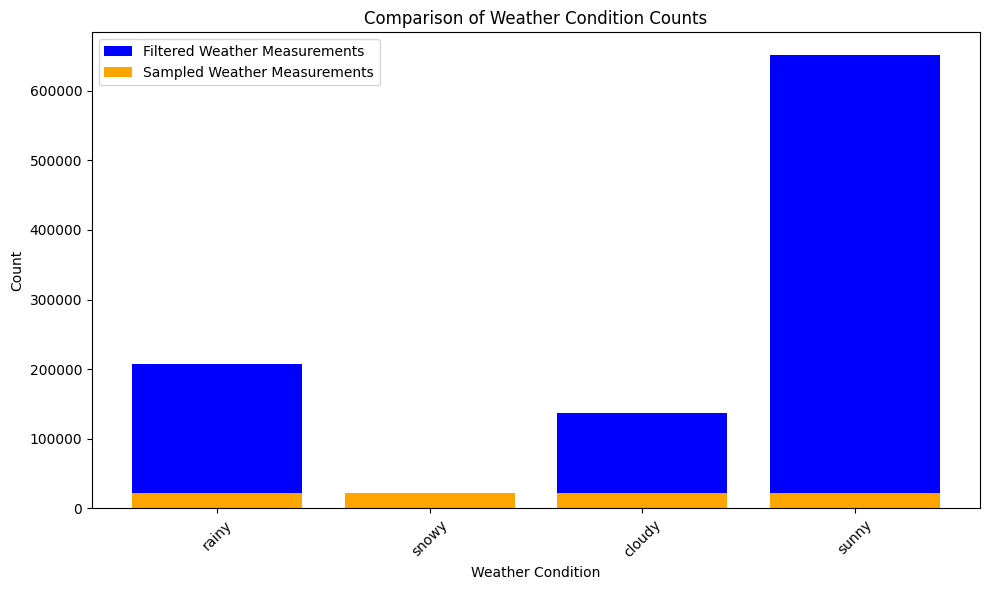

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Collecting counts for filtered DataFrame
filtered_weather_counts = filtered_weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_C).count().toPandas()

# Collecting counts for sampled DataFrame
sampled_weather_counts = sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_C).count().toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))

plt.bar(filtered_weather_counts[WEATHER_CONDITION_C], filtered_weather_counts['count'], color='blue', label='Filtered Weather Measurements')
plt.bar(sampled_weather_counts[WEATHER_CONDITION_C], sampled_weather_counts['count'], color='orange', label='Sampled Weather Measurements')

plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.title('Comparison of Weather Condition Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


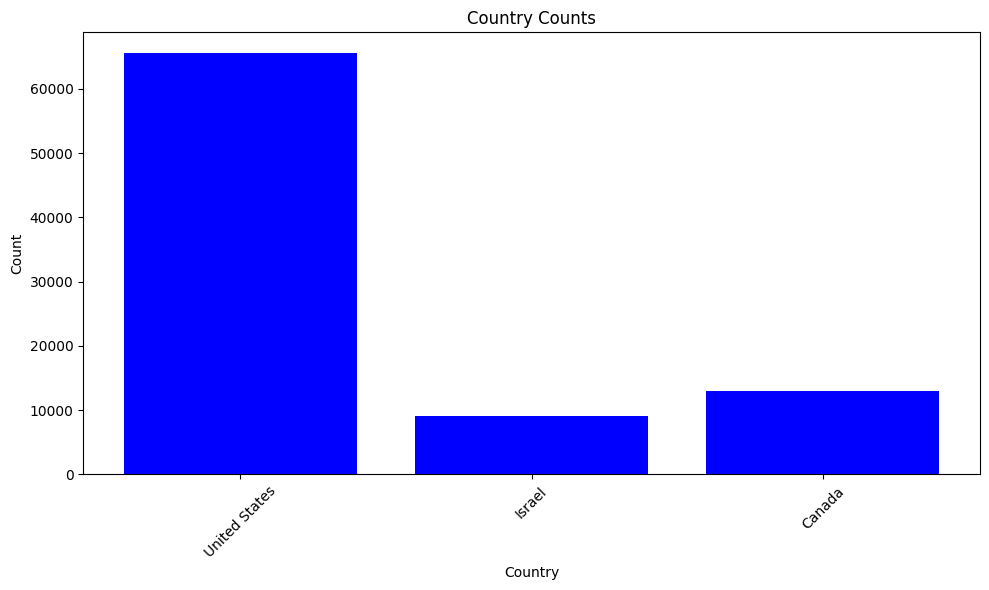

In [0]:
# sampled_weather_measurements_df.groupBy("country").count().show()
country_counts = sampled_weather_measurements_df.groupBy("country").count().toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(country_counts["country"], country_counts['count'], color='blue')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Country Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

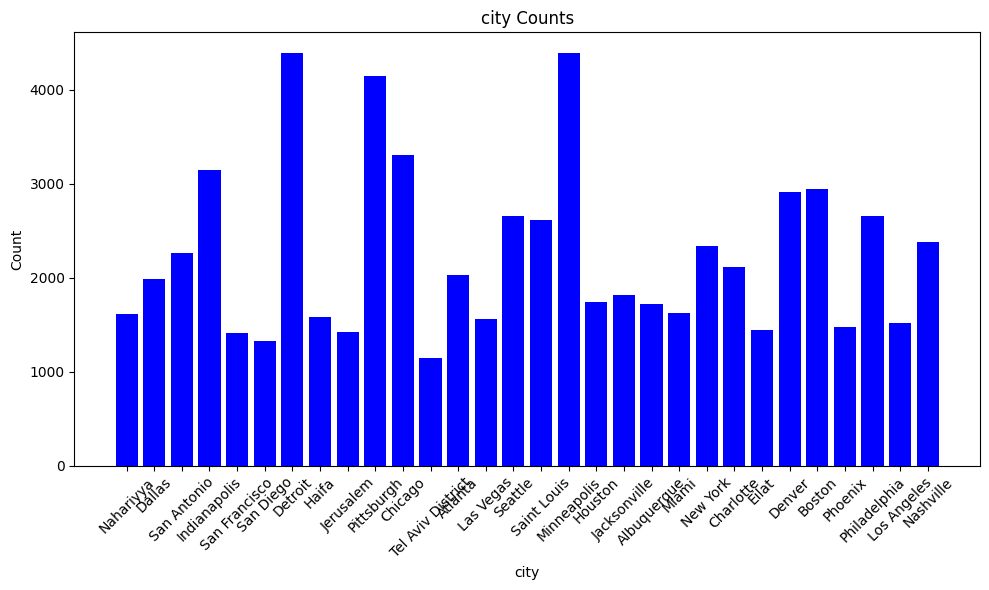

In [0]:
# sampled_weather_measurements_df.groupBy("city").count().show(30)
city_counts = sampled_weather_measurements_df.groupBy("city").count().toPandas()

# Select the first 30 rows
first_30_countries = city_counts.head(30)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(first_30_countries["city"], first_30_countries['count'], color='blue')
plt.xlabel('city')
plt.ylabel('Count')
plt.title('city Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### finding corelation between all columns with column 'weather_condition' for feature extraction

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder

# Assuming you have a PySpark DataFrame named 'sampled_weather_measurements_df'

# Convert PySpark DataFrame to pandas DataFrame
data = sampled_weather_measurements_df.select(["humidity", "pressure", "temperature", "wind_direction", "wind_speed", "weather_condition"]).toPandas()

# Convert the target variable to numeric values
label_encoder = LabelEncoder()
data['weather_condition'] = label_encoder.fit_transform(data['weather_condition'])

# Split data into features and target variable
X = data.drop('weather_condition', axis=1)
y = data['weather_condition']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Correlation Analysis
correlation_matrix = X_train.corrwith(y_train)
correlation_with_target = correlation_matrix.abs().sort_values(ascending=False)
print(correlation_with_target)

# 2. Feature Importance (Random Forest)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance_sorted)

# 3. Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

rfe = RFE(estimator=rf, n_features_to_select=3)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print(selected_features_rfe)

# 4. Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
selected_features_lasso = X_train.columns[model.get_support()]
print(selected_features_lasso)

humidity          0.230902
wind_speed        0.074042
wind_direction    0.066886
temperature       0.027611
pressure          0.025262
dtype: float64
                importance
temperature       0.415956
humidity          0.178655
wind_direction    0.177800
pressure          0.158422
wind_speed        0.069168
Index(['humidity', 'temperature', 'wind_direction'], dtype='object')
Index(['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed'], dtype='object')


##removing unwanted columns

In [0]:
sampled_weather_measurements_new_df = sampled_weather_measurements_df.drop('datetime', 'latitude', 'longitude', 'wind_speed')

#### Splitting the dataset into test and train data
- Split the sampled_weather_measurements_df dataframe into train_df and test_df dataframes
- using a 80% - 20% ratio and specifying the random seed
- persit the outcomes to improve performance

In [0]:


train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

# Persist the train_df and test_df dataframes in memory
# to improve performance for subsequent operations

train_df.persist()
test_df.persist()

DataFrame[weather_condition: string, datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, city: string, country: string, latitude: double, longitude: double]

#### Applying a limit to the training dataframe in order to prevent an Internal Server Error in DataBricks


In [0]:
# Apply a limit to the training dataframe in order to prevent an Internal Server Error in DataBricks
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [0]:
# Print the size of the train_df dataframe
print(f'Train set size:  {train_df.count()} instances')

# Print the size of the test_df dataframe
print(f'Test set size:   {test_df.count()} instances')

Train set size:  70037 instances
Test set size:   17605 instances


# Machine learning pipeline

#### Defining some columns and empty lists for further usage

In [0]:
# Define a list of column names corresponding to numerical features
NUMERICAL_FEATURES = [HUMIDITY_C,
                      PRESSURE_C,
                      TEMPERATURE_C,
                      WIND_DIRECTION_C,
                      WIND_SPEED_C,
                      LATITUDE_C,
                      LONGITUDE_C]

# Define an empty list for column names corresponding to categorical features
CATEGORICAL_FEATURES = []

# Define the column name corresponding to the target variable
TARGET_VARIABLE_COL = WEATHER_CONDITION_C

# Define the column name for the predicted target variable
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

# Define the column name for the label column
LABEL_COL = 'label'

# Define the column name for the prediction column
PREDICTION_COL = 'prediction'

# Define the column name for the features column
FEATURES_COL = 'features'

# Define the column name for the scaled features column
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

#### Saving the model to a specific path

In [0]:
'''
    Save a PySpark model to a specified path.
    
    Args:
        - model: the PySpark model to be saved
        - path: the file path to save the model
        - append_datetime: whether to append current datetime to the path (True by default)
'''

def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:

    
    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    model.write().overwrite().save(path)
    print(path)

#### Fitting a pipeline for encoding categorical features and scaling numerical features.
- This code defines variables for column names that are important for a machine learning task and creates a pipeline to prepare data for a machine learning model.
- The focus is on encoding categorical features (non-numeric data) and scaling numerical features.

In [0]:
'''
    Fit a pipeline for encoding categorical features and scaling numerical features.
  
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
'''

def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:

    # Import necessary modules
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)
    
    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers], 
                            handleInvalid='keep')
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)
    
    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)
    
    # Define the stages of the pipeline
    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    
    # Create the pipeline
    pipeline = Pipeline(stages=stages)

    # Fit the pipeline with the input dataframe
    transformer = pipeline.fit(dataframe)

    # Return the fitted pipeline
    return transformer

##### Loading the encoding pipeline if LOAD_ENCODING_PIPELINE is True, otherwise create a new encoding pipeline


In [0]:
data_encoder = PipelineModel.load(ENCODING_PIPELINE_PATH) if LOAD_ENCODING_PIPELINE \
               else encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

In [0]:
# Check if SAVE_COMPUTATIONS is True and LOAD_ENCODING_PIPELINE is False
if SAVE_COMPUTATIONS and not LOAD_ENCODING_PIPELINE:
    # Save the data_encoder model to the ENCODING_PIPELINE_PATH
    save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/data_encoder-20240304-223406


#### Applying the encoding pipeling to training and testing dataset

In [0]:
# Apply the encoding pipeline to the training dataset and store the result in encoded_train_df
encoded_train_df = data_encoder.transform(train_df)

# Apply the encoding pipeline to the testing dataset and store the result in encoded_test_df
encoded_test_df = data_encoder.transform(test_df)

###A simple Random Forest model
#####Note that training a Machine Learning model could take up to several hours, so this simple Random Forest model, among with all the others in the Notebook, is going to be loaded from the filesystem

#### Training a random forest model with the encoded training data

In [0]:
# Import the required libraries
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

# Train a random forest model with the encoded training data
rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)

#### Applying the trained random forest model to the encoded testing data

In [0]:
# Apply the trained random forest model to the encoded testing data
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

#### Creating an IndexToString transformer to convert index predictions to their corresponding string labels

In [0]:
# Import the required libraries
from pyspark.ml.feature import IndexToString

# Create an IndexToString transformer to convert index predictions to their corresponding string labels
predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [0]:
# Apply the IndexToString transformer to convert the indexed predictions to their corresponding string labels
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

#### Evaluating the predictions 
Evaluating the predictions made by a model by computing and printing metrics such as accuracy, precision, recall, and F1-score


In [0]:
def eval_predictions(predictions: DataFrame) -> None:
    '''
    Evaluates the predictions made by a model by computing and printing metrics such as accuracy, precision, recall, and F1-score
    
    Args:
        predictions: a DataFrame that has at least a `LABEL_COL` and a `PREDICTION_COL`
    '''
    # Import the required libraries
    from sklearn.metrics import precision_score, recall_score, accuracy_score

    # Convert the labels and predictions columns from Spark DataFrame to NumPy arrays using Koalas
    labels = predictions.select(LABEL_COL).to_koalas().to_numpy()
    predictions = predictions.select(PREDICTION_COL).to_koalas().to_numpy()

    # Compute the precision, recall, F1-score, and accuracy
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(labels, predictions)    

    # Print the metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')
    return accuracy, precision,recall,f1_score

#### Actually calling the above method

In [0]:
# Call the eval_predictions function and pass rnd_forest_predictions as an argument
rnd_accuracy, rnd_precision,rnd_recall,rnd_f1_score = eval_predictions(rnd_forest_predictions)

Accuracy: 0.6072138596989491
Precision: 0.5883268664078302
Recall: 0.6077078120491228
F1-score: 0.5978603115683608


#### Plotting a confusion matrix
Creates a Visual Confusion Matrix:  It takes predictions and true values, then generates a color-coded grid. This grid helps you see how well your machine learning model is classifying different categories.

Calculates the Confusion Matrix: It figures out how often your model predicts each category correctly and where it makes mistakes  (true vs. predicted).

Makes it Readable: Adds labels, adjusts colors, and optionally normalizes the values to make the confusion matrix easier to understand.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given DataFrame
    
    Args:
        - predictions_df: a DataFrame that has at least a TARGET_VARIABLE_COL and a PREDICTED_TARGET_VARIABLE_COL
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''
    
    # Import required libraries
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    # Convert the labels and predictions columns from Spark DataFrame to NumPy arrays using Koalas
    labels = predictions_df.select(TARGET_VARIABLE_COL).to_koalas().to_numpy()
    predictions = predictions_df.select(PREDICTED_TARGET_VARIABLE_COL).to_koalas().to_numpy()

    # Set the title if not provided
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute the confusion matrix
    cm = confusion_matrix(labels, predictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, predictions)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Set the tick labels and axis labels
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    # Set the y-axis limits
    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Add the text annotations
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

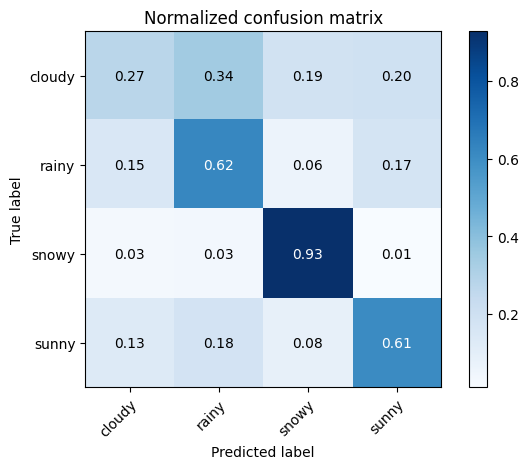

In [0]:
# Call the plot_confusion_matrix function and pass rnd_forest_predictions as an argument, with normalization enabled
plot_confusion_matrix(rnd_forest_predictions, normalize=True)

In [0]:
# Check if the flag SAVE_COMPUTATIONS is set to True and the flag LOAD_PRETRAINED_MODELS is set to False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    # Save the RandomForest model to the specified path
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest-20240304-223724


## Hyperparameter Tuning

In this section, we construct a pipeline that encapsulates all the steps performed thus far:

- The data encoding pipeline defined previously.
- An instance of a Machine Learning model.
- An IndexToString transformer that converts numerical predictions into their corresponding label versions.

Additionally, we incorporate a K-Fold Cross Validation step to fine-tune certain hyperparameters and obtain a more accurate estimate of the model's generalization performance.

### Random Forest Model

For the Random Forest model, it has been observed that even without configuring any hyperparameters, satisfactory results can still be achieved in predicting certain classes.

Let's explore whether tuning the max depth of the trees (`maxDepth`) and the number of trees (`numTrees`) can lead to improved overall performance.


- The code prepares the data by converting text-like features (e.g., "cloudy") into numbers and adjusting numerical features to improve the model's performance.
- It builds a Random Forest Classifier, a machine learning model that uses a collection of decision trees to make predictions.
- It searches for the best settings (like the number of trees and their depth) for the Random Forest model using a technique called cross-validation.
- It sets up a system to measure how accurate the model is in its predictions.


In [0]:
def random_forest_pipeline(dataframe: DataFrame,
                           numerical_features: List[str],
                           categorical_features: List[str],
                           target_variable: str,
                           features_col: str,
                           with_std: bool = True,
                           with_mean: bool = False,
                           k_fold: int = 5) -> CrossValidatorModel:
  
    # Import necessary libraries
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline

    # Perform feature encoding using the encoding_pipeline function
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    # Create a RandomForestClassifier object
    classifier = RandomForestClassifier(featuresCol=features_col, labelCol=LABEL_COL)

    # Create an IndexToString transformer to convert prediction indices to string labels
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    # Define the stages of the pipeline
    stages = [data_encoder, classifier, predictions_idx_to_str]

    # Create a pipeline with the defined stages
    pipeline = Pipeline(stages=stages)

    # Construct a grid of parameters to search over using a ParamGridBuilder
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [3, 5, 8]) \
        .addGrid(classifier.numTrees, [10, 50, 100]) \
        .build()

    # Create a MulticlassClassificationEvaluator for evaluating model performance
    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    # Create a CrossValidator for hyperparameter tuning
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    # Fit the CrossValidator to the data and obtain the best model
    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
# Load the pre-trained Random Forest Cross Validator model if LOAD_PRETRAINED_MODELS is True
# Otherwise, create a new model by calling the random_forest_pipeline function with the appropriate arguments
rnd_forest_cv_model = CrossValidatorModel.load(RANDOM_FOREST_CV_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                      else random_forest_pipeline(train_df,
                                                  NUMERICAL_FEATURES,
                                                  CATEGORICAL_FEATURES,
                                                  TARGET_VARIABLE_COL,
                                                  FEATURES_COL)

In [0]:
# Get the best model from the Random Forest Cross Validator
rnd_forest_cv_model_obj = rnd_forest_cv_model.bestModel.stages[-2]._java_obj

# Print the parameters of the best model
print('Best model according to k-fold cross validation:')
print(f' - numTrees=[{rnd_forest_cv_model_obj.getNumTrees()}]')
print(f' - maxDepth=[{rnd_forest_cv_model_obj.getMaxDepth()}]')

Best model according to k-fold cross validation:
 - numTrees=[50]
 - maxDepth=[8]


In [0]:
# Check if SAVE_COMPUTATIONS is True and LOAD_PRETRAINED_MODELS is False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    # Save the Random Forest Cross Validator model
    save_pyspark_model(rnd_forest_cv_model, RANDOM_FOREST_CV_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest_cv-20240304-225204


In [0]:
# Use the Random Forest Cross Validator model to make predictions on the test dataset
rnd_forest_cv_predictions = rnd_forest_cv_model.transform(test_df)

#### Evaluating Predictions

In [0]:
# Evaluate the predictions from the Random Forest Cross Validation model
rnd_cv_accuracy, rnd_cv_precision,rnd_cv_recall,rnd_cv_f1_score=eval_predictions(rnd_forest_cv_predictions)

Accuracy: 0.6285714285714286
Precision: 0.6156062688854103
Recall: 0.6289670900370682
F1-score: 0.6222149635030891


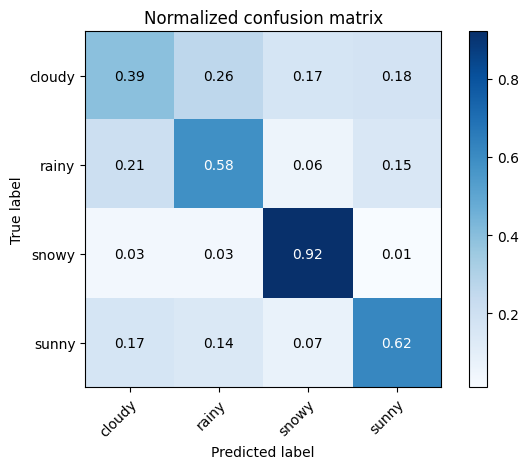

In [0]:
# Plot the confusion matrix for the random forest cross-validation predictions
# Set the normalize parameter to True to normalize the values in the confusion matrix
plot_confusion_matrix(rnd_forest_cv_predictions, normalize=True)

#### Logistic Regression
- The code gets the data ready for the machine learning model.  It converts text-based features into numbers and scales numerical features for better performance.
- The code builds a Logistic Regression classifier. This model is used to predict a category (like whether it will rain or not) based on the given data
-  It uses cross-validation to find the best settings (hyperparameters) for the Logistic Regression model. This means trying different combinations of settings to find the ones that make the most accurate predictions.
- It sets up a way to measure the accuracy of the model's predictions.
- It prepares to convert the model's output (which will be in numerical form) back into the original labels for easier understanding.

In [0]:
def logistic_regression_pipeline(dataframe: DataFrame,
                                 numerical_features: List[str],
                                 categorical_features: List[str],
                                 target_variable: str,
                                 features_col: str,
                                 with_std: bool = True,
                                 with_mean: bool = False,
                                 k_fold: int = 5) -> CrossValidatorModel:

    # Import necessary libraries
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline

    # Perform encoding pipeline
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)

    # Configure the logistic regression classifier
    classifier = LogisticRegression(featuresCol=features_col, labelCol=LABEL_COL)

    # Convert predicted indexes to target variable labels
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    # Set the stages for the pipeline
    stages = [data_encoder, classifier, predictions_idx_to_str]

    # Create the pipeline
    pipeline = Pipeline(stages=stages)

    # Construct the parameter grid for the cross validation
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxIter, [10, 100, 1000]) \
        .addGrid(classifier.regParam, [0.0, 0.05, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    # Set the evaluator for the cross validation
    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    # Create the cross validator
    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    # Fit the cross validator to the data
    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
# Load the logistic regression cross-validation model if LOAD_PRETRAINED_MODELS is True
# Otherwise, train the model using logistic_regression_pipeline function
log_reg_cv_model = CrossValidatorModel.load(LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else logistic_regression_pipeline(train_df,
                                                     NUMERICAL_FEATURES,
                                                     CATEGORICAL_FEATURES,
                                                     TARGET_VARIABLE_COL,
                                                     FEATURES_COL)

In [0]:
# Retrieve the best model from the cross validation model
log_reg_cv_best_model_obj = log_reg_cv_model.bestModel.stages[-2]._java_obj

# Print the hyperparameters of the best model
print('Best model according to k-fold cross validation:')
print(f' - regParam=[{log_reg_cv_best_model_obj.getRegParam()}]')
print(f' - elasticNetParam=[{log_reg_cv_best_model_obj.getElasticNetParam()}]')
print(f' - maxIter=[{log_reg_cv_best_model_obj.getMaxIter()}]')

Best model according to k-fold cross validation:
 - regParam=[0.0]
 - elasticNetParam=[0.0]
 - maxIter=[100]


In [0]:
# Save the logistic regression cross-validation model if SAVE_COMPUTATIONS is True and LOAD_PRETRAINED_MODELS is False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(log_reg_cv_model, LOGISTIC_REGRESSION_CV_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/log_reg_cv-20240304-231845


In [0]:
# Use the logistic regression cross-validation model to make predictions on the test set
log_reg_cv_predictions = log_reg_cv_model.transform(test_df)

In [0]:
# Evaluate the predictions from logistic regression cross-validation model
log_reg_cv_accuracy, log_reg_cv_precision,log_reg_cv_recall,log_reg_cv_f1_score=eval_predictions(log_reg_cv_predictions)

Accuracy: 0.5908548707753479
Precision: 0.5693179847445088
Recall: 0.5914257875218797
F1-score: 0.5801613508904814


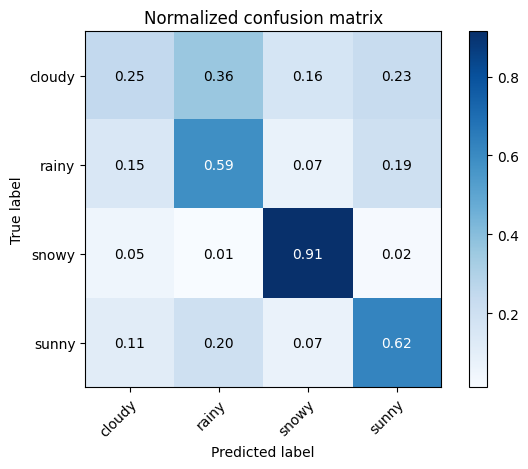

In [0]:
# Task: Plot the confusion matrix for logistic regression cross-validation predictions
# Parameters: 
# - log_reg_cv_predictions: The DataFrame containing the predictions made by logistic regression cross-validation model
# - normalize=True: Normalize the values in the confusion matrix
plot_confusion_matrix(log_reg_cv_predictions, normalize=True)

## Comparison with OpenWeather Forecasts

In the subsequent analysis, we conduct a comparison with forecasts from OpenWeather, obtained via their free APIs.

It's important to note that the weather measurements values we obtain are forecasts, whereas our model is trained on real measured values. Therefore, it's highly probable that we won't achieve the same level of performance as observed on the test set.



We retreive the 5-days weather forcases for a given city from from the API provided by open Weather, and consume it to compare our predictions with the the retreived data

In [0]:
# Define the OpenWeatherMap API key
API_KEY = '57fe401be548737b0d267e7abda86175'

# Define the city names for weather forecasts
CITY_NAMES = ['Toronto']

# Define the OpenWeatherMap model to use
openweather_model = rnd_forest_cv_model

# Define the column name for OpenWeatherMap forecasts
OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [0]:
# Function to retrieve 5-days weather forecasts for a given city
def get_5_days_forecasts_df(city_name: str, api_key: str) -> DataFrame:
    import requests
  
    # Create a Spark Session
    spark = SparkSession.builder \
        .appName("WeatherForecast") \
        .getOrCreate()
  
    # API URL for retrieving weather forecasts
    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    # Send API request and retrieve JSON response
    res = requests.get(API_URL).json()

    # Extract coordinates for the city
    coord = res['city']['coord']

    # Extract latitude and longitude
    latitude = float(coord['lat'])
    longitude = float(coord['lon'])
    
    # Initialize an empty list to store forecast rows
    forecasts = []

    # Iterate through each forecast
    for forecast in res['list']:
        # Extract main weather parameters
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        # Extract datetime for the forecast
        datetime = forecast['dt_txt']
        
        # Convert main weather parameters to float
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        # Extract weather condition
        weather_condition = weather[0]['main']
        
        # Create a row object for the forecast
        forecast_row = Row(datetime=datetime,
                           humidity=humidity,
                           pressure=pressure,
                           temperature=temperature,
                           wind_direction=wind_direction,
                           wind_speed=wind_speed,
                           weather_condition=weather_condition,
                           city=city_name,
                           latitude=latitude,
                           longitude=longitude)

        # Append forecast row to the list
        forecasts.append(forecast_row)
        
    # Create a DataFrame from the list of forecast rows
    return spark.createDataFrame(forecasts)

In [0]:
# Initialize an empty DataFrame
openweather_forecasts_df = None

# Iterate through each city name
for city_name in CITY_NAMES:
    # Check if the DataFrame is empty
    if openweather_forecasts_df is None:
        # If empty, retrieve the 5-days weather forecasts for the city
        openweather_forecasts_df = get_5_days_forecasts_df(city_name, API_KEY)
    else:
        # If not empty, union the existing DataFrame with the new forecasts
        openweather_forecasts_df = openweather_forecasts_df.union(get_5_days_forecasts_df(city_name, API_KEY))

In [0]:
# Collect the distinct weather conditions from the openweather_forecasts_df DataFrame
weather_conditions = openweather_forecasts_df.select(TARGET_VARIABLE_COL).distinct().collect()

# Extract the weather conditions from the collected data and create an array
weather_conditions_array = [row[0] for row in weather_conditions]

# Calculate the weather conditions aggregation dictionary using the weather_conditions_array
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_array)

In [0]:
# Replace the weather conditions in openweather_forecasts_df using the weather_conditions_dict
openweather_forecasts_df = openweather_forecasts_df.replace(weather_conditions_dict)

In [0]:
# Filter the openweather_forecasts_df DataFrame to keep only rows where the TARGET_VARIABLE_COL is in WEATHER_CONDITIONS
openweather_forecasts_df = openweather_forecasts_df.filter(openweather_forecasts_df[TARGET_VARIABLE_COL].isin(unique_weather_conditions))

In [0]:
# Convert openweather_forecasts_df to a Koalas DataFrame and display the first 5 rows
openweather_forecasts_df.to_koalas().head(5)

,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,latitude,longitude
0,2024-04-04 00:00:00,94.0,995.0,276.43,90.0,7.19,rainy,Toronto,43.7001,-79.4163
1,2024-04-04 03:00:00,96.0,995.0,275.70,89.0,5.78,rainy,Toronto,43.7001,-79.4163
2,2024-04-04 06:00:00,97.0,994.0,275.31,123.0,4.42,rainy,Toronto,43.7001,-79.4163
3,2024-04-04 09:00:00,98.0,995.0,274.07,92.0,4.74,snowy,Toronto,43.7001,-79.4163
4,2024-04-04 12:00:00,98.0,996.0,274.21,81.0,5.55,snowy,Toronto,43.7001,-79.4163


In [0]:
# Apply the trained machine learning model to make predictions on the openweather_forecasts_df dataset
openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

In [0]:
openweather_forecasts_predictions \
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL)) \
    .select([DATETIME_C, CITY_C, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL]) \
    .to_koalas().head(10)

,datetime,city,openweather_forecast,predicted_weather_condition
0,2024-04-04 00:00:00,Toronto,rainy,rainy
1,2024-04-04 03:00:00,Toronto,rainy,rainy
2,2024-04-04 06:00:00,Toronto,rainy,rainy
3,2024-04-04 09:00:00,Toronto,snowy,snowy
4,2024-04-04 12:00:00,Toronto,snowy,snowy
5,2024-04-04 15:00:00,Toronto,snowy,snowy
6,2024-04-04 18:00:00,Toronto,snowy,snowy
7,2024-04-04 21:00:00,Toronto,snowy,snowy
8,2024-04-05 00:00:00,Toronto,snowy,snowy
9,2024-04-05 03:00:00,Toronto,snowy,snowy


/root/.ipykernel/869/command-1381586767474183-166225917:39: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


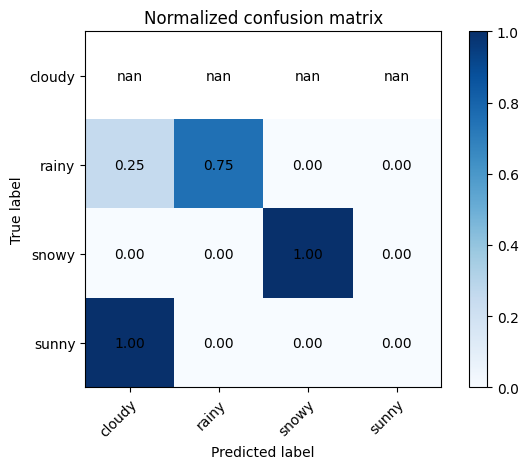

In [0]:
# Plot a confusion matrix for the openweather_forecasts_predictions dataframe
plot_confusion_matrix(openweather_forecasts_predictions, normalize=True)

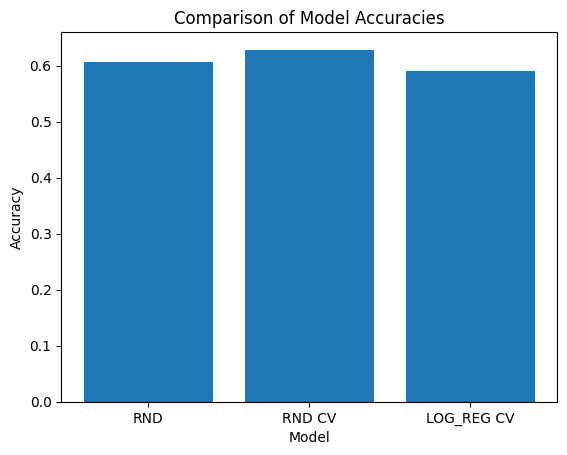

In [0]:
# Need to do it
# Generate a bar plot to compare the accuracies
import matplotlib.pyplot as plt

models = ['RND', 'RND CV','LOG_REG CV']
accuracies = [rnd_accuracy,rnd_cv_accuracy, log_reg_cv_accuracy ]

plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

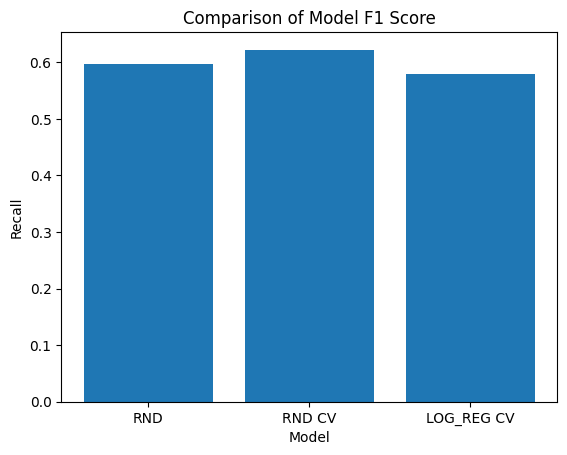

In [0]:
# Generate a bar plot to compare the recall
import matplotlib.pyplot as plt

models = ['RND', 'RND CV','LOG_REG CV']
accuracies = [rnd_f1_score,rnd_cv_f1_score, log_reg_cv_f1_score ]

plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Model F1 Score')
plt.show()